# Tests 20240122

- Found that the manual dataset, 1 sec duration, hamming window is the best when rate etc are unchanged
- Going to test window length, rate, and minimum/maximum freq now (all against the original set up)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
import os 
import glob
import csv
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as confusion_matrix_sklearn

from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.data_handling.data_feeding import BatchGenerator
from ketos.neural_networks.resnet import ResNetInterface
from ketos.audio.audio_loader import AudioFrameLoader, AudioLoader, SelectionTableIterator
from ketos.audio.spectrogram import MagSpectrogram
from ketos.neural_networks.dev_utils.detection import batch_load_audio_file_data, filter_by_threshold
from ketos.data_handling.data_feeding import JointBatchGen

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('done importing packages')

done importing packages


C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Test window length

In [5]:
# Load in user inputs 
main_folder = r'E:\tests\tests-20240122'

# These are copied from the 2sec edited folder 
neg_folder = r'E:\tests\tests-20240122\inputs\annots\neg'
pos_folder = r'E:\tests\tests-20240122\inputs\annots\pos'

file_durations_file = r'E:\tests\all_file_durations_complete.xlsx'
file_durations = pd.read_excel(file_durations_file)

data_folder = r'D:\ringed-seal-data'

spectro_file = r'E:\tests\tests-20240122\inputs\spectro-files\spec_config_100-1200Hz-0.032-hamm.json'
recipe_file = r'E:\tests\tests-20240122\inputs\resnet_recipe-1.json'
annot_folder = r'E:\tests\tests-20240122\inputs\annots'
db_names = r'E:\tests\tests-20240122\hamm-0.032window-db.h5'
model_names = r'E:\tests\tests-20240122\hamm-0.032window.kt'
temp_folders = r'E:\tests\tests-20240122\rs-temp-6-hamm0.032'

In [6]:
pos_folder = r'E:\tests\tests-20240122\inputs\annots\pos'

# Get list of all csv files in that folder
files_pos = glob.glob(pos_folder + "/*.csv")

site_names = []
num_annots = []

# For each csv file
for file in files_pos:

    annots = pd.read_csv(file)

    site_name = file.split('\\')[-1].split('.')[0].split('_')[0]

    site_names.append(site_name)
    num_annots.append(len(annots))

ULU22_val = num_annots[site_names.index('ULU2022')]
other_val = sum(num_annots) - ULU22_val
all_annots = sum(num_annots)

ulu_2022_split = 0.32
all_else_split = 1 - ulu_2022_split

dataset_split = [0.7, 0.2, 0.1]

train_annots = round(all_annots*dataset_split[0])
val_annots = round(all_annots*dataset_split[1])
test_annots = round(all_annots*dataset_split[2])

# ulu22 vals
ulu22_tr = round(train_annots*ulu_2022_split)
ulu22_va = round(val_annots*ulu_2022_split)
ulu22_te = round(test_annots*ulu_2022_split)

ulu22_leftovers = ULU22_val - ulu22_tr - ulu22_va - ulu22_te

if ulu22_leftovers < 0:
    ulu22_te = ulu22_te + ulu22_leftovers

if ulu22_leftovers > 0 :
    ulu22_tr = ulu22_tr + ulu22_leftovers

all_ulu = ulu22_tr + ulu22_te + ulu22_va

if all_ulu != ULU22_val:
    print('Something went wrong with Ulu')
    exit()

ulu2022_vals = [ulu22_tr, ulu22_va, ulu22_te]

# rest vals
rest_tr = round(train_annots*all_else_split)
rest_va = round(val_annots*all_else_split)
rest_te = round(test_annots*all_else_split)

# totals
all_added = rest_tr + rest_va + rest_te

if all_added < other_val:
    leftover = other_val - all_added
    rest_tr = rest_tr + leftover

if all_added > other_val:
    leftover = all_added - other_val
    rest_va = rest_va - leftover

all_added2 = rest_tr + rest_va + rest_te

cb_perc = num_annots[0]/all_added2
kk_perc = num_annots[1]/all_added2
ulu_perc = num_annots[4]/all_added2

# split into other site vals
cb_tr = round(cb_perc*rest_tr)
cb_va = round(cb_perc*rest_va)
cb_te = round(cb_perc*rest_te)
total_cb = cb_tr + cb_va + cb_te
if total_cb < num_annots[0]:
    leftover_cb = num_annots[0] - total_cb
    cb_tr = cb_tr + leftover_cb
if total_cb > num_annots[0]:
    leftover_cb = num_annots[0] - total_cb
    cb_va = cb_va + leftover_cb
cb_vals = [cb_tr, cb_va, cb_te]

kk_tr = round(kk_perc*rest_tr)
kk_va = round(kk_perc*rest_va)
kk_te = round(kk_perc*rest_te)
total_kk = kk_tr + kk_va + kk_te
if total_kk < num_annots[1]:
    leftover_kk = num_annots[1] - total_kk
    kk_tr = kk_tr + leftover_kk
if total_kk > num_annots[1]:
    leftover_kk = num_annots[1] - total_kk
    kk_va = kk_va + leftover_kk
kk_vals = [kk_tr, kk_va, kk_te]
    
ulu_tr = round(ulu_perc*rest_tr)
ulu_va = round(ulu_perc*rest_va)
ulu_te = round(ulu_perc*rest_te)
total_ulu = ulu_tr + ulu_va + ulu_te
if total_ulu < num_annots[4]:
    leftover_ulu = num_annots[4] - total_ulu
    ulu_tr = ulu_tr + leftover_ulu
if total_ulu > num_annots[4]:
    leftover_ulu = num_annots[4] - total_ulu
    ulu_va = ulu_va + leftover_ulu
ulu_vals = [ulu_tr, ulu_va, ulu_te]

print('ulu22 vals (tr, va, te): ' + str(ulu2022_vals) + ', total: ' + str(sum(ulu2022_vals)))
print('ulu vals (tr, va, te): ' + str(ulu_vals) + ', total: ' + str(sum(ulu_vals)))
print('kk vals (tr, va, te): ' + str(kk_vals) + ', total: ' + str(sum(kk_vals)))
print('cb vals (tr, va, te): ' + str(cb_vals) + ', total: ' + str(sum(cb_vals)))

ulu22 vals (tr, va, te): [1037, 296, 143], total: 1476
ulu vals (tr, va, te): [669, 191, 95], total: 955
kk vals (tr, va, te): [1348, 384, 192], total: 1924
cb vals (tr, va, te): [133, 38, 19], total: 190


In [7]:
## Create Database ##

# negatives tables and standarize for ketos
ulu_neg = pd.read_excel(neg_folder + '\\' + 'ULU-negs-joined.xlsx')
ulu_neg = ulu_neg.ffill()
ulu_neg = sl.standardize(table=ulu_neg)
print('Negatives standardized? ' + str(sl.is_standardized(ulu_neg)))

ulu2022_neg = pd.read_excel(neg_folder + '\\' + 'ULU2022-negs-joined.xlsx')
ulu2022_neg = ulu2022_neg.ffill()
ulu2022_neg = sl.standardize(table=ulu2022_neg)
print('Negatives standardized? ' + str(sl.is_standardized(ulu2022_neg)))

kk_neg = pd.read_excel(neg_folder + '\\' + 'KK-negs-joined.xlsx')
kk_neg = kk_neg.ffill()
kk_neg = sl.standardize(table=kk_neg)
print('Negatives standardized? ' + str(sl.is_standardized(kk_neg)))

cb_neg = pd.read_excel(neg_folder + '\\' + 'CB-negs-joined.xlsx')
cb_neg = cb_neg.ffill()
cb_neg = sl.standardize(table=cb_neg)
print('Negatives standardized? ' + str(sl.is_standardized(cb_neg)))

# positives tables
ulu_pos = pd.read_csv(pos_folder + '\\' + 'ULU_all_formatted_1sec.csv')
ulu_pos = ulu_pos.ffill()
ulu_pos = sl.standardize(table=ulu_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(ulu_pos)))

ulu2022_pos = pd.read_csv(pos_folder + '\\' + 'ULU2022_all_formatted_1sec.csv')
ulu2022_pos = ulu2022_pos.ffill()
ulu2022_pos = sl.standardize(table=ulu2022_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(ulu2022_pos)))

kk_pos = pd.read_csv(pos_folder + '\\' + 'KK_all_formatted_1sec.csv')
kk_pos = kk_pos.ffill()
kk_pos = sl.standardize(table=kk_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(kk_pos)))

cb_pos = pd.read_csv(pos_folder + '\\' + 'CB_all_formatted_1sec.csv')
cb_pos = cb_pos.ffill()
cb_pos = sl.standardize(table=cb_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(cb_pos)))

# join into complete tables

ulu_pos_tr = ulu_pos.head(ulu_vals[0])
ulu_pos_va = ulu_pos[ulu_vals[0]:ulu_vals[0] + ulu_vals[1]]
ulu_pos_te = ulu_pos.tail(ulu_vals[2])

ulu_neg_tr = ulu_neg.head(ulu_vals[0])
ulu_neg_va = ulu_neg[ulu_vals[0]:ulu_vals[0] + ulu_vals[1]]
ulu_neg_te = ulu_neg.tail(ulu_vals[2])

ulu_tr = pd.concat([ulu_pos_tr, ulu_neg_tr])
ulu_va = pd.concat([ulu_pos_va, ulu_neg_va])
ulu_te = pd.concat([ulu_pos_te, ulu_neg_te])

ulu2022_pos_tr = ulu2022_pos.head(ulu2022_vals[0])
ulu2022_pos_va = ulu2022_pos[ulu2022_vals[0]:ulu2022_vals[0] + ulu2022_vals[1]]
ulu2022_pos_te = ulu2022_pos.tail(ulu2022_vals[2])

ulu2022_neg_tr = ulu2022_neg.head(ulu2022_vals[0])
ulu2022_neg_va = ulu2022_neg[ulu2022_vals[0]:ulu2022_vals[0] + ulu2022_vals[1]]
ulu2022_neg_te = ulu2022_neg.tail(ulu2022_vals[2])

ulu2022_tr = pd.concat([ulu2022_pos_tr, ulu2022_neg_tr])
ulu2022_va = pd.concat([ulu2022_pos_va, ulu2022_neg_va])
ulu2022_te = pd.concat([ulu2022_pos_te, ulu2022_neg_te])

kk_pos_tr = kk_pos.head(kk_vals[0])
kk_pos_va = kk_pos[kk_vals[0]:kk_vals[0] + kk_vals[1]]
kk_pos_te = kk_pos.tail(kk_vals[2])

kk_neg_tr = kk_neg.head(kk_vals[0])
kk_neg_va = kk_neg[kk_vals[0]:kk_vals[0] + kk_vals[1]]
kk_neg_te = kk_neg.tail(kk_vals[2])

kk_tr = pd.concat([kk_pos_tr, kk_neg_tr])
kk_va = pd.concat([kk_pos_va, kk_neg_va])
kk_te = pd.concat([kk_pos_te, kk_neg_te])

cb_pos_tr = cb_pos.head(cb_vals[0])
cb_pos_va = cb_pos[cb_vals[0]:cb_vals[0] + cb_vals[1]]
cb_pos_te = cb_pos.tail(cb_vals[2])

cb_neg_tr = cb_neg.head(cb_vals[0])
cb_neg_va = cb_neg[cb_vals[0]:cb_vals[0] + cb_vals[1]]
cb_neg_te = cb_neg.tail(cb_vals[2])

cb_tr = pd.concat([cb_pos_tr, cb_neg_tr])
cb_va = pd.concat([cb_pos_va, cb_neg_va])
cb_te = pd.concat([cb_pos_te, cb_neg_te])

# final three tables

train = pd.concat([ulu_tr, ulu2022_tr, cb_tr, kk_tr])
val = pd.concat([ulu_va, ulu2022_va, cb_va, kk_va])
test = pd.concat([ulu_te, ulu2022_te, cb_te, kk_te])

Negatives standardized? True
Negatives standardized? True
Negatives standardized? True
Negatives standardized? True
Positives standardized? True
Positives standardized? True
Positives standardized? True
Positives standardized? True


In [8]:
def drop_rows(file_durations, table):

    drop = []

    print('cleaning training table of original length ' + str(len(table)))

    for idex, row in table.iterrows():
    
        # filename is row[0], end time is idex.end
        index = file_durations.loc[file_durations['filename'] == row.name[0]].index
        duration = file_durations['duration'][index].values[0]
    
        if duration < row.end:
            # drop the row corresponding to that sel_id and filename from the dataframe
            drop.append(idex)
    
        if row.start < 0:
            drop.append(idex)
    
    print('Number of rows to drop (note, one entry may be in list twice): ' + str(len(drop)))

    return drop

In [9]:
drop_rows_tr = drop_rows(file_durations, train)
train = train.drop(drop_rows_tr)
print(len(train))
drop_rows_va = drop_rows(file_durations, val)
val = val.drop(drop_rows_va)
print(len(val))
drop_rows_te = drop_rows(file_durations, test)
test = test.drop(drop_rows_te)
print(len(test))

cleaning training table of original length 6374
Number of rows to drop (note, one entry may be in list twice): 10
6362
cleaning training table of original length 1818
Number of rows to drop (note, one entry may be in list twice): 4
1813
cleaning training table of original length 898
Number of rows to drop (note, one entry may be in list twice): 2
894


In [12]:
# join into a database
# Load the spectrogram representation & parameters, this returns a dict 
spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

# Create a table called "train" in the database, defined by db_name, using the "train" selections table, the spectrogram config, and the audio data 
# Behind the hood, this creates an AudioLoader and AudioWriter Ketos function which generates the spectrograms for each selection 
# For the specific spectrogram in this case, the spectrograms are of size [1500,56] where 56 refers to the frequency dimension and 1500 refers to the time dimension 
# The size of the spectrogram is 1500*56, which is 84000
dbi.create_database(output_file=db_names,  # empty brackets
                    dataset_name=r'train', selections=train, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_names,  # empty brackets
                    dataset_name=r'val', selections=val, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_names,  # empty brackets
                    dataset_name=r'test', selections=test, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|██████████████████████████████████████████████████████████████████████████████| 6362/6362 [02:32<00:00, 41.59it/s]


6362 items saved to E:\tests\tests-20240122\hamm-0.032window-db.h5


100%|██████████████████████████████████████████████████████████████████████████████| 1813/1813 [00:42<00:00, 43.11it/s]


1813 items saved to E:\tests\tests-20240122\hamm-0.032window-db.h5


100%|████████████████████████████████████████████████████████████████████████████████| 894/894 [00:20<00:00, 42.81it/s]

894 items saved to E:\tests\tests-20240122\hamm-0.032window-db.h5


In [16]:
# Set the random seed for numpy and tensorflow 
np.random.seed(1000)
tf.random.set_seed(2000)

# Set the batch size and number of epochs for training
batch_size = 16
n_epochs = 40

# Set the log folder and checkpoint folder 
log_folder = main_folder + '\\' + 'logs-hamm-0.32'
checkpoint_folder = main_folder + '\\' + 'checkpoints-hamm-0.32'

# Open the database file in read mode
db = dbi.open_file(db_names, 'r')

# Open the training and validation tables respectively 
train_data = dbi.open_table(db, "/train/data")
val_data = dbi.open_table(db, "/val/data")

# Create batches of training data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                    output_transform_func=ResNetInterface.transform_batch,
                                    shuffle=True, refresh_on_epoch_end=True)

# Create batches of validation data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                   output_transform_func=ResNetInterface.transform_batch,
                                   shuffle=False, refresh_on_epoch_end=False)

# Build the ResNet model file based off of the recipe file - this creates a "ResNetInterface" object 
resnet = ResNetInterface.build(recipe_file)

# Set the training and validation generators to the batch generators created above 
resnet.train_generator = train_generator
resnet.val_generator = val_generator

# Set the model log and checkpoint directory 
resnet.log_dir = log_folder
resnet.checkpoint_dir = checkpoint_folder

# Train the model, looping through all of the training and validation data 
# See code map for more information
resnet.train_loop(n_epochs=n_epochs, verbose=False, log_csv=True, csv_name='log-hamm-0.32-manual.csv')

# Close the database 
db.close()

# Save the model file, and keep track of the spectrogram parameters used to generate that model 
resnet.save(model_names, audio_repr_file=spectro_file)

print('Done')

NameError: name 'model_name' is not defined

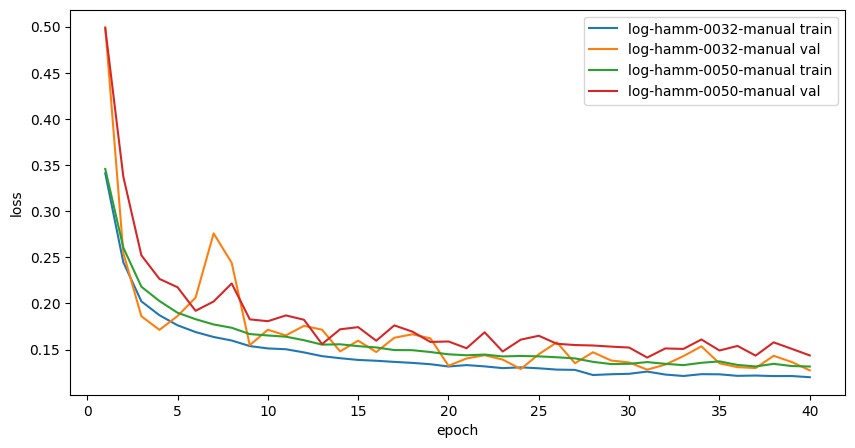

In [20]:
# Get path to folder containing logs 
log_folder = r'E:\tests\tests-20240122\logs-hamm-0.32'

files = glob.glob(log_folder  + "/*.csv")

fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
#axes.set_ylim(0.1, 0.20)

for file in files:

    # Read the log file 
    log_file = pd.read_csv(file)

    labell = file.split('\\')[-1].split(".")[0]
    
    # Get the training and validation losses 
    tr_results = log_file[log_file['dataset']=='train']
    va_results = log_file[log_file['dataset']=='val']
    
    # Plot the loss curves 
    sns.lineplot(data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
    sns.lineplot(data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto') 

## Test Frequency Range 

From above, we found that a smaller window was better with a set freq range, let's try freq range from 0-1200, and from 100-2000. So going forward we can see if we need to lower the bottom frequency or raise the upper freq bound.

In [21]:
# Get number of spectrogram tests 
spectro_folder = r'E:\tests\tests-20240122\inputs\spectro-files'
spectro_files = glob.glob(spectro_folder + "/*.json")

recipe = r'E:\tests\tests-20240122\inputs\resnet_recipe-1.json'

spectro_test_folder = r'E:\tests\tests-20240122'

db_names = [spectro_test_folder + '\\' + '0-1200Hz.h5', spectro_test_folder + '\\' + '100-2000Hz.h5']

model_names = [spectro_test_folder + '\\' + 'rs-spec-0-1200Hz.kt', spectro_test_folder + '\\' + 'rs-spec-100-2000Hz.kt']

temp_folders = [spectro_test_folder + '\\' + 'rs-temp-1-01200', spectro_test_folder + '\\' + 'rs-temp-2-1002000']

In [22]:
# For each spectro file:
for idex, spec in enumerate(spectro_files):
    
    # join into a database
    # Load the spectrogram representation & parameters, this returns a dict 
    spec_cfg = load_audio_representation(spec, name="spectrogram")

    # Create a table called "train" in the database, defined by db_name, using the "train" selections table, the spectrogram config, and the audio data 
    # Behind the hood, this creates an AudioLoader and AudioWriter Ketos function which generates the spectrograms for each selection 
    # For the specific spectrogram in this case, the spectrograms are of size [1500,56] where 56 refers to the frequency dimension and 1500 refers to the time dimension 
    # The size of the spectrogram is 1500*56, which is 84000
    dbi.create_database(output_file=db_names[idex],  # empty brackets
                        dataset_name=r'train', selections=train, data_dir=data_folder,
                        audio_repres=spec_cfg)
    
    dbi.create_database(output_file=db_names[idex],  # empty brackets
                        dataset_name=r'val', selections=val, data_dir=data_folder,
                        audio_repres=spec_cfg)
    
    dbi.create_database(output_file=db_names[idex],  # empty brackets
                        dataset_name=r'test', selections=test, data_dir=data_folder,
                        audio_repres=spec_cfg)

100%|██████████████████████████████████████████████████████████████████████████████| 6362/6362 [02:45<00:00, 38.33it/s]


6362 items saved to E:\tests\tests-20240122\0-1200Hz.h5


100%|██████████████████████████████████████████████████████████████████████████████| 1813/1813 [00:42<00:00, 42.83it/s]


1813 items saved to E:\tests\tests-20240122\0-1200Hz.h5


100%|████████████████████████████████████████████████████████████████████████████████| 894/894 [00:20<00:00, 42.72it/s]


894 items saved to E:\tests\tests-20240122\0-1200Hz.h5


100%|██████████████████████████████████████████████████████████████████████████████| 6362/6362 [02:07<00:00, 50.02it/s]


6362 items saved to E:\tests\tests-20240122\100-2000Hz.h5


100%|██████████████████████████████████████████████████████████████████████████████| 1813/1813 [00:36<00:00, 49.90it/s]


1813 items saved to E:\tests\tests-20240122\100-2000Hz.h5


100%|████████████████████████████████████████████████████████████████████████████████| 894/894 [00:18<00:00, 47.61it/s]

894 items saved to E:\tests\tests-20240122\100-2000Hz.h5


In [24]:
for idex, spec in enumerate(spectro_files): 
    
    # join into a database
    # Load the spectrogram representation & parameters, this returns a dict 
    spec_cfg = load_audio_representation(spec, name="spectrogram")

    # Set the random seed for numpy and tensorflow 
    np.random.seed(1000)
    tf.random.set_seed(2000)
    
    # Set the batch size and number of epochs for training
    batch_size = 16
    n_epochs = 40
    
    # Set the log folder and checkpoint folder 
    log_folder = spectro_test_folder + '\\' + 'logs' + str(idex)
    checkpoint_folder = spectro_test_folder + '\\' + 'checkpoints' + str(idex)
    
    # Open the database file in read mode
    db = dbi.open_file(db_names[idex], 'r')
    
    # Open the training and validation tables respectively 
    train_data = dbi.open_table(db, "/train/data")
    val_data = dbi.open_table(db, "/val/data")
    
    # Create batches of training data of size batch size, using the specified data table 
    # This returns indices of the data in each batch along with their labels 
    train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                        output_transform_func=ResNetInterface.transform_batch,
                                        shuffle=True, refresh_on_epoch_end=True)
    
    # Create batches of validation data of size batch size, using the specified data table 
    # This returns indices of the data in each batch along with their labels 
    val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                       output_transform_func=ResNetInterface.transform_batch,
                                       shuffle=False, refresh_on_epoch_end=False)
    
    # Build the ResNet model file based off of the recipe file - this creates a "ResNetInterface" object 
    resnet = ResNetInterface.build(recipe)
    
    # Set the training and validation generators to the batch generators created above 
    resnet.train_generator = train_generator
    resnet.val_generator = val_generator
    
    # Set the model log and checkpoint directory 
    resnet.log_dir = log_folder
    resnet.checkpoint_dir = checkpoint_folder
    
    # Train the model, looping through all of the training and validation data 
    # See code map for more information
    resnet.train_loop(n_epochs=n_epochs, verbose=False, log_csv=True, csv_name='log.csv')
    
    # Close the database 
    db.close()
    
    # Save the model file, and keep track of the spectrogram parameters used to generate that model 
    resnet.save(model_names[idex], audio_repr_file=spec)

    print('Done spectro ' + str(idex+1))

Done spectro 1
Done spectro 2


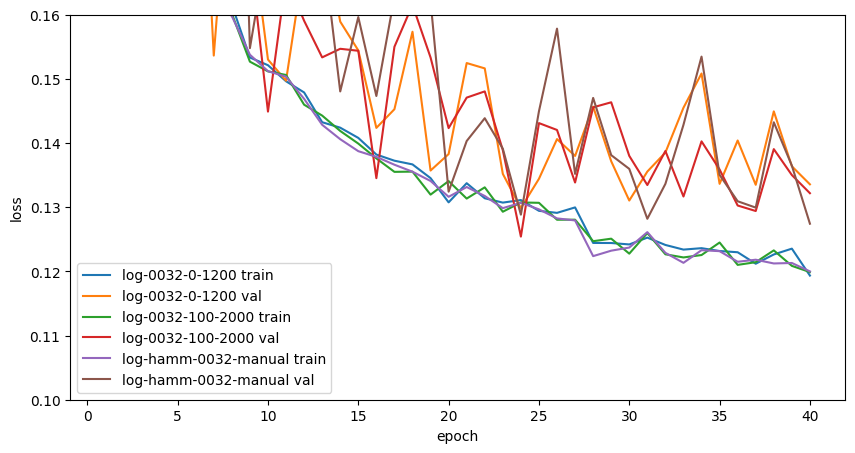

In [33]:
# Get path to folder containing logs 
log_folder = r'E:\tests\tests-20240122\logs-1002000'

files = glob.glob(log_folder  + "/*.csv")

fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
axes.set_ylim(0.1, 0.16)

for file in files:

    # Read the log file 
    log_file = pd.read_csv(file)

    labell = file.split('\\')[-1].split(".")[0]
    
    # Get the training and validation losses 
    tr_results = log_file[log_file['dataset']=='train']
    va_results = log_file[log_file['dataset']=='val']
    
    # Plot the loss curves 
    sns.lineplot(data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
    sns.lineplot(data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto') 

From the above, we can see that frequency range from 0-2000 has no effect on the loss curves of the model. Because the spectrograms have been manually checked at 100-1200Hz, going forward we will continue to use this frequency range.